# 🗣️ Conversational RAG using a Chat Message Store

_by [Sebastian Husch Lee](https://www.linkedin.com/in/sebastian-husch-lee) and [Vladimir Blagojevic](https://www.linkedin.com/in/blagojevicvladimir)_

In this notebook, we'll show how to incorporate a conversational history into a RAG pipeline to enable multi-turn conversations with our documents, using our experimental components: `InMemoryChatMessageStore`, `ChatMessageRetriever`, and `ChatMessageWriter`.

## Installation

Install Haystack, `haystack-experimental` and `datasets` with pip:

In [ ]:
!pip install -U "haystack-experimental>=0.15.0" datasets

## Enter OpenAI API key

In [ ]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

## Conversational Pipeline

Below we build a simple conversational pipeline using the new chat components. The example focuses on enabling multi turn conversations and demonstrates how session level chat history is managed through `chat_history_id`.

### Create a Chat Message Store

Conversation history is stored as `ChatMessage` objects inside an `InMemoryChatMessageStore`. The `ChatMessageRetriever` reads past messages from the store, while the `ChatMessageWriter` appends new messages after each interaction. Together, these components allow the pipeline to persist and reuse chat history across turns.

Import these components from the [haystack-experimental](https://github.com/deepset-ai/haystack-experimental) package:

In [3]:
from haystack_experimental.chat_message_stores.in_memory import InMemoryChatMessageStore
from haystack_experimental.components.retrievers import ChatMessageRetriever
from haystack_experimental.components.writers import ChatMessageWriter

# Chat History components
message_store = InMemoryChatMessageStore()
message_retriever = ChatMessageRetriever(message_store)
message_writer = ChatMessageWriter(message_store)

### Build the Pipeline

In [24]:
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.components.converters import OutputAdapter
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage


pipeline = Pipeline()

# components for RAG
pipeline.add_component(
    "prompt_builder",
    ChatPromptBuilder(
        template=[
            ChatMessage.from_system("You are a helpful AI assistant that answers users questions."),
            ChatMessage.from_user("{{query}}")
        ],
        required_variables="*"
    )
)
pipeline.add_component("llm", OpenAIChatGenerator(model="gpt-4o"))

# components for chat history retrieval and storage
pipeline.add_component("message_retriever", ChatMessageRetriever(message_store))
pipeline.add_component("message_writer", ChatMessageWriter(message_store))
pipeline.add_component(
    "message_joiner",
    OutputAdapter(template="{{ prompt + replies }}", output_type=list[ChatMessage], unsafe=True)
)

# connections
pipeline.connect("prompt_builder.prompt", "message_retriever.current_messages")
pipeline.connect("prompt_builder.prompt", "message_joiner.prompt")
pipeline.connect("message_retriever.messages", "llm.messages")
pipeline.connect("llm.replies", "message_joiner.replies")
pipeline.connect("message_joiner", "message_writer.messages")

Unsafe mode is enabled. This allows execution of arbitrary code in the Jinja template. Use this only if you trust the source of the template.


🚅 Components
  - prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
  - message_retriever: ChatMessageRetriever
  - message_writer: ChatMessageWriter
  - message_joiner: OutputAdapter
🛤️ Connections
  - prompt_builder.prompt -> message_retriever.current_messages (list[ChatMessage])
  - prompt_builder.prompt -> message_joiner.prompt (list[ChatMessage])
  - llm.replies -> message_joiner.replies (list[ChatMessage])
  - message_retriever.messages -> llm.messages (list[ChatMessage])
  - message_joiner.output -> message_writer.messages (list[ChatMessage])

### Visualize the pipeline

Visualize the pipeline with the [`show()`](https://docs.haystack.deepset.ai/docs/visualizing-pipelines) method to confirm the connections are correct.

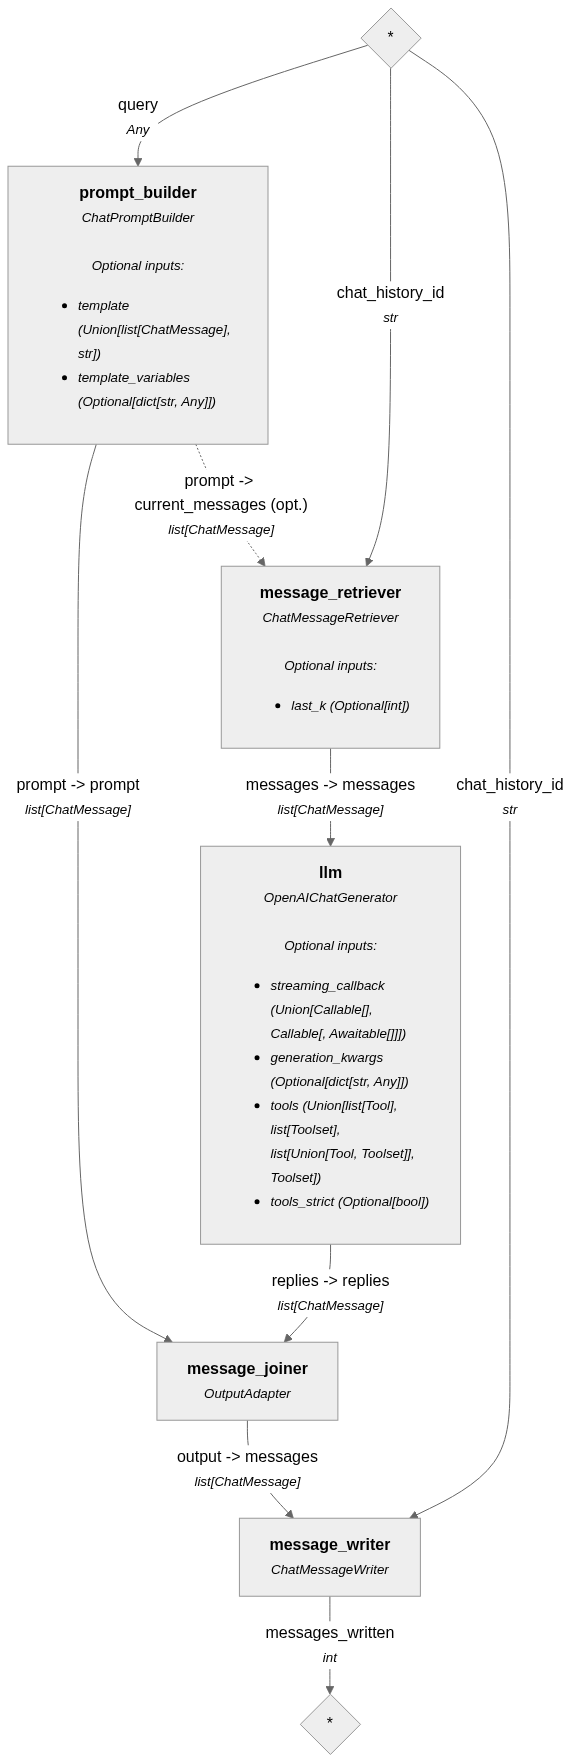

In [5]:
pipeline.show()

### Run the Pipeline

- Test the pipeline with some queries. 
- Ensure that in every request we add a `chat_history_id` parameter so that we know which conversational history we'd like to retrieve and write to.

Here are example queries you can try:

* *Describe Haystack by deepset in a few words.*
* *What do people use it for?*

In [6]:
chat_history_id = "user_123_session_1"

while True:
    question = input("Enter your question or Q to exit.\n🧑 ")
    if question == "Q":
        break

    res = pipeline.run(
        data={
            "prompt_builder": {"query": question},
            "message_retriever": {"chat_history_id": chat_history_id},
            "message_writer": {"chat_history_id": chat_history_id},
        },
        include_outputs_from={"llm"}
    )
    print(f'🤖 {res["llm"]["replies"][0].text}')

Enter your question or Q to exit.
🧑  Describe Haystack by deepset in a few words.


🤖 Open-source framework for building production QA, semantic search, and RAG pipelines.


Enter your question or Q to exit.
🧑  What do people use it for?


🤖 People use Haystack to build production-ready systems that let apps find, read, and answer questions from large collections of documents.

Common uses:
- Retrieval-augmented generation (RAG) and open-domain question answering over PDFs, docs, websites, and databases.
- Semantic/enterprise search with vector search for more relevant results than keyword search.
- Chatbots and conversational knowledge assistants that pull answers from company knowledge bases.
- Automated customer support (answering FAQs, ticket summarization, troubleshooting).
- Legal, compliance, and research workflows for extracting facts, citations, and summaries from corpora.
- Document ingestion, preprocessing (OCR, splitting, metadata), and indexing into vector stores for downstream models.

Why people pick it: it provides modular retriever+reader/generator pipelines, connectors to common vector stores and data sources, easy integration with LLMs and embedding models, and tools for evaluation and production deplo

Enter your question or Q to exit.
🧑  Q


We can also inspect the stored chat history in the `InMemoryChatMessageStore`

In [15]:
chat_history = message_store.retrieve_messages(chat_history_id=chat_history_id, last_k=None)

for msg in chat_history:
    print(f"ROLE: {msg.role.value}")
    print(f"{msg.text}\n")

ROLE: user
Describe Haystack by deepset in a few words.

ROLE: assistant
Open-source framework for building production QA, semantic search, and RAG pipelines.

ROLE: user
What do people use it for?

ROLE: assistant
People use Haystack to build production-ready systems that let apps find, read, and answer questions from large collections of documents.

Common uses:
- Retrieval-augmented generation (RAG) and open-domain question answering over PDFs, docs, websites, and databases.
- Semantic/enterprise search with vector search for more relevant results than keyword search.
- Chatbots and conversational knowledge assistants that pull answers from company knowledge bases.
- Automated customer support (answering FAQs, ticket summarization, troubleshooting).
- Legal, compliance, and research workflows for extracting facts, citations, and summaries from corpora.
- Document ingestion, preprocessing (OCR, splitting, metadata), and indexing into vector stores for downstream models.

Why people p

### Switching to a New Chat Session
- Now we can update the `chat_history_id` to change to a new chat session with an empty chat history

Here are example queries you can try:

* *Who founded deepset?*

In [26]:
# Update the chat history ID
chat_history_id = "user_123_session_2"

while True:
    question = input("Enter your question or Q to exit.\n🧑 ")
    if question == "Q":
        break

    res = pipeline.run(
        data={
            "prompt_builder": {"query": question},
            "message_retriever": {"chat_history_id": chat_history_id},
            "message_writer": {"chat_history_id": chat_history_id},
        },
        include_outputs_from={"llm"}
    )
    print(f'🤖 {res["llm"]["replies"][0].text}')

Enter your question or Q to exit.
🧑  Who founded deepset?


🤖 deepset was founded by Malte Pietsch, Milos Rusic, and Timo Möller. The company is known for its work in natural language processing and is the creator of the open-source NLP framework Haystack.


Enter your question or Q to exit.
🧑  Q


Now we can fetch the chat history stored under the `"user_123_session_2"` ID.

In [27]:
chat_history = message_store.retrieve_messages(chat_history_id="user_123_session_2", last_k=None)

for msg in chat_history:
    print(f"ROLE: {msg.role.value}")
    print(f"{msg.text}\n")

ROLE: user
Who founded deepset?

ROLE: assistant
deepset was founded by Malte Pietsch, Milos Rusic, and Timo Möller. The company is known for its work in natural language processing and is the creator of the open-source NLP framework Haystack.



### Other Utility Methods

We have also included other utility methods inside of `InMemoryChatMessageStore` including:
- count_messages
- delete_messages
- delete_all_messages

For more information check out our ChatMessageStore docs at https://docs.haystack.deepset.ai/reference/experimental-chatmessage-store-api 

## Conversational RAG Pipeline using Agent

In conversational systems, simply pre-pending the chat history to the new user message is not enough to perform RAG effectively. There needs to be a mechanism to rephrase the user's query based on the conversation history to ensure relevant documents are retrieved. For instance, if the first user query is "*What's the first name of Einstein?*" and the second query is "*Where was he born?*", the system should understand that "he" refers to Einstein. The rephrasing mechanism should then modify the second query to "*Where was Einstein born?*" to retrieve the correct documents.

We can use an Agent to call its RAG tool with a rephrased version of the user's query. 

### Create a Document Store and Index Documents

Create an index with [seven-wonders](https://huggingface.co/datasets/bilgeyucel/seven-wonders) dataset:

In [42]:
from haystack import Document
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.document_stores.in_memory import InMemoryDocumentStore
from datasets import load_dataset

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]

document_store = InMemoryDocumentStore()
document_store.write_documents(documents=docs)

151

### Build the Conversational Agent

In [61]:
from haystack import Pipeline
from haystack.components.agents import Agent
from haystack.components.builders import ChatPromptBuilder, PromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.tools import PipelineTool
from haystack.components.generators.utils import print_streaming_chunk

# Build the RAG Tool
rag_pipeline = Pipeline()

rag_pipeline.add_component(
    "doc_retriever", InMemoryBM25Retriever(document_store=document_store, top_k=3)
)
rag_pipeline.add_component(
    "builder",
    PromptBuilder(
        template="""Supporting documents:
{%- if documents|length > 0 %}
{%- for doc in documents %}
Document [{{ loop.index }}] :
{{ doc.content }}
{% endfor -%}
{%- else %}
No relevant documents found.
{% endif %}""",
        required_variables="*"
    )
)

rag_pipeline.connect("doc_retriever.documents", "builder.documents")

rag_tool = PipelineTool(
    pipeline=rag_pipeline,
    name="rag_tool",
    description="A tool for fetching information on the seven wonders of the ancient world.",
    input_mapping={"query": ["doc_retriever.query"]},
    output_mapping={"builder.prompt": "rag_output"},
)

# Build the Agent
conversational_agent = Pipeline()

conversational_agent.add_component(
    "agent",
    Agent(
        system_prompt="""You are a helpful AI assistant that answers users questions grounded in a set supporting documents.
If any questions are asked about the seven wonders always use the `rag_tool` to fetch supporting documents.
Stay concise in your answers.
""",
        chat_generator=OpenAIChatGenerator(),
        tools=[rag_tool],
        streaming_callback=print_streaming_chunk,
    )
)

# components for chat history storage and retrieval
conversational_agent.add_component("message_retriever", ChatMessageRetriever(memory_store))
conversational_agent.add_component("message_writer", ChatMessageWriter(memory_store))

# connections for Agent
conversational_agent.connect("message_retriever.messages", "agent.messages")
conversational_agent.connect("agent.messages", "message_writer")

🚅 Components
  - agent: Agent
  - message_retriever: ChatMessageRetriever
  - message_writer: ChatMessageWriter
🛤️ Connections
  - agent.messages -> message_writer.messages (list[ChatMessage])
  - message_retriever.messages -> agent.messages (list[ChatMessage])

### Let's have a conversation 😀

Now, run the pipeline with the relevant inputs.

Here are some example queries and follow ups you can try:

* *What does Rhodes Statue look like?* - *Who built it?* - *Did he destroy it?*
* *Where is Gardens of Babylon?* - *When was it built?*

In [62]:
chat_history_id = "user_123_session_4"

while True:
    question = input("Enter your question or Q to exit.\n🧑 ")
    if question == "Q":
        break

    conversational_agent.run(
        data={
            "message_retriever": {"current_messages": [ChatMessage.from_user(question)], "chat_history_id": chat_history_id},
            "message_writer": {"chat_history_id": chat_history_id}
        }
    )
    # No need to print the output since we are streaming it

Enter your question or Q to exit.
🧑  What does Rhodes Statue look like?


[TOOL CALL]
Tool: rag_tool 
Arguments: {"query":"Colossus of Rhodes appearance description Helios statue pose torch crown straddling harbour ancient sources"}

[TOOL RESULT]
{'rag_output': 'Supporting documents:\nDocument [1] :\nAlso, the fallen statue would have blocked the harbour, and since the ancient Rhodians did not have the ability to remove the fallen statue from the harbour, it would not have remained visible on land for the next 800 years, as discussed above. Even neglecting these objections, the statue was made of bronze, and engineering analyses indicate that it could not have been built with its legs apart without collapsing under its own weight.[29]\nMany researchers have considered alternative positions for the statue which would have made it more feasible for actual construction by the ancients.[29][30] There is also no evidence that the statue held a torch aloft; the records simply say that after completion, the Rhodians kindled the "torch of freedom". A relief in a ne

Enter your question or Q to exit.
🧑  Who built it?


[TOOL CALL]
Tool: rag_tool 
Arguments: {"query":"Who built the Colossus of Rhodes Chares of Lindos builder 280 BC"}

[TOOL RESULT]
{'rag_output': "Supporting documents:\nDocument [1] :\nThe Colossus of Rhodes (Ancient Greek: ὁ Κολοσσὸς Ῥόδιος, romanized:\xa0ho Kolossòs Rhódios Greek: Κολοσσός της Ρόδου, romanized:\xa0Kolossós tes Rhódou)[a] was a statue of the Greek sun-god Helios, erected in the city of Rhodes, on the Greek island of the same name, by Chares of Lindos in 280\xa0BC. One of the Seven Wonders of the Ancient World, it was constructed to celebrate the successful defence of Rhodes city against an attack by Demetrius Poliorcetes, who had besieged it for a year with a large army and navy.\nAccording to most contemporary descriptions, the Colossus stood approximately 70 cubits, or 33 metres (108 feet) high – approximately the height of the modern Statue of Liberty from feet to crown – making it the tallest statue in the ancient world.[2] It collapsed during the earthquake of 2

Enter your question or Q to exit.
🧑  Q


✅ Notice that this time, with the help of query rephrasing, we've built a conversational RAG pipeline that can handle follow-up queries and retrieve the relevant documents.